# HHL algorithm

We present a simple example for a linear system $A \vert x \rangle = \vert b \rangle$ where $A \in \mathbb{R}^{2 \times 2}$.
<br> 
<br> 
adapted from Zaman et al., IEEE Access 11, 77117 (2023)
<br>
1. Classical solution and choice of evolution time t
2. Set up of the HHL algorithm
3. Evaluation of the HHL result

In [1]:
#---- Imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
import numpy as np
import math as m
import scipy as sci
import matplotlib.pyplot as plt

## 1. Classical solution

Classical solution of the system of linear equations and calculation of eigenvalues of matrix $A$:

\begin{equation}
\lambda_0=\frac{2}{3}\,,\quad \lambda_1=\frac{4}{3}
\end{equation}

In [3]:
#----Define matrix A and vector b
A = np.array([[1,-1/3],[-1/3,1]])
b = np.transpose([0,1])

#----Calculate solution
x = np.matmul(np.linalg.inv(A),b)

#----Find eigenvalues ([1] for eigenvectors)
lam = np.linalg.eigh(A)[0]

#----Print result
print('classical solution: ',x)
print('eigenvalues: ', lam)

classical solution:  [0.375 1.125]
eigenvalues:  [0.66666667 1.33333333]


Choice of the evolution time $t$ (and the number of control qubits $n$) which is an important parameter for the accuracy of the HHL algorithm.

Here $t=3\pi/4$ and thus the **rescaled integer eigenvalues** are given by

\begin{equation}
\tilde{\lambda_0}=1\,,\quad \tilde{\lambda_1}=2
\end{equation}

Recall:

- 2 eigenvalues since input register $n_b=1$

- 4 positions on unit circle since control (or clock) register $n=2$

- two values fit $e^{i\lambda_0 t}=e^{i\pi/2}$ and $e^{i\lambda_1 t}=e^{i\pi}$


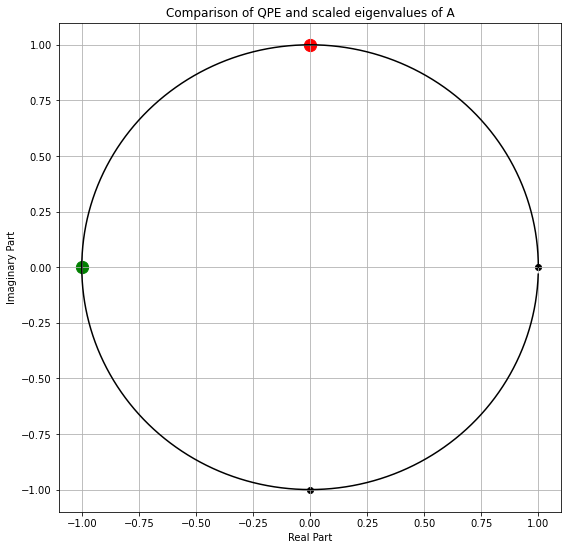

In [4]:
#----Set number of control qubits
n = 2 # vary this parameter to find states where the QPE works accurately

#----Set evolution time
t = 3*np.pi/4 # vary this parameter to scale the eigenvalues to the given states (given by control qubits)

#----Number of states in the control register
N_control = 2**n

#----Define unit circle
circ_x = np.cos(np.arange(0,2,0.01)*np.pi)
circ_y = np.sin(np.arange(0,2,0.01)*np.pi)

#----Plot unit circle
plt.figure(figsize=(9,9))
plt.plot(circ_x,circ_y,color='black')
plt.grid('on')
plt.xlabel('Real Part') , plt.ylabel('Imaginary Part')
plt.title('Comparison of QPE and scaled eigenvalues of A')

#----Set (black) dots for the possible states in the control register
#----These black dots illustrate where the QPE is accurate
for k in range(N_control): 
    dot = np.exp(1j*k*np.pi*2/N_control) # resolution is scaled by control qubits
    plt.scatter(np.real(dot),np.imag(dot),color='black')

#----Rescaled lambda_0    
dot1 = np.exp(1j*t*2/3)
plt.scatter(np.real(dot1),np.imag(dot1),color='red',s=150)

#----Rescaled lambda_1
dot2 = np.exp(1j*t*4/3)
plt.scatter(np.real(dot2),np.imag(dot2),color='green',s=150)

## 2. Set up of the HHL algorithm

Define the different registers:
- input register: to load $\vert b \rangle$
- control register: set resolution for QPE, here: 2 qubits
- ancilla qubit: auxillary qubit which is important to obtain the wanted solution
- classical register for the measurement

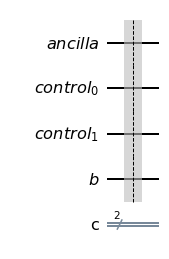

In [5]:
#----Create quantum + classical registers
control = QuantumRegister(2, name='control')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

#----Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, control, input, measurement)
circuit.barrier()
circuit.draw('mpl')

Define the QFT and inverse QFT routines:

In [6]:
#----Inverse QFT (IQFT)
def qft_dagger(circ, q, n):
    circ.h(control[1]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cu(0, 0, -np.pi/float(2**(k-j)), 0, q[k], q[j]);
            circ.h(control[0]);
            circ.swap(control[0], control[1]);

#----Forward QFT
def qft(circ, q, n):
    circ.swap(control[0], control[1]);
    circ.h(control[0]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cu(0, 0, np.pi/float(2**(k-j)), 0, q[k], q[j]);
            circ.h(control[1]);

Define the QPE and inverse QPE

Recall that we have calculated all conditional unitaries C-$U$ and C-$U^2$ and the corresponding inverse unitaries already explicitely! In "reality" a Hamiltonian simulation has to be run $U=e^{iAt}$. 

In [7]:
#----Quantum Phase Estimation
def qpe(circ, control, target):
    circuit.barrier()

    #----e^{i*A*t} = U
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, control[0], input,label='U');

    #----e^{i*A*t*2} = U^2
    circuit.cu(np.pi, np.pi, 0, 0, control[1], input, label='U2');
    circuit.barrier();

    #----Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, control, 2)

#----Inverse Quantum Phase Estimation    
def inv_qpe(circ, control, target):

    #----Perform a QFT on the register holding the eigenvalues
    qft(circuit, control, 2)
    circuit.barrier()

    #----e^{i*A*t*2} = U^-2
    circuit.cu(np.pi, np.pi, 0, 0, control[1], input, label='U2');

    # circuit.barrier();
    #----e^{i*A*t} = U^-1
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, control[0], input,label='U');
    circuit.barrier()

Define the HHL module

Eigenvalue inversion (EI) applies **conditional rotation gates $R_Y(\theta)$** to encode inverse eigenvalues with 

\begin{equation}
\theta_j = 2 \arcsin\left(\frac{1}{\lambda_j}\right)\,,
\end{equation}

which results to $\theta_0=\pi$ and $\theta_1=\pi/3$.

In [8]:
def hhl(circ, ancilla, control, input, measurement):
    #----QPE
    qpe(circ, control, input)
    circuit.barrier()

    #----Eigenvalue inversion (EI) with controlled Ry gates
    circuit.cry(np.pi, control[0], ancilla)
    circuit.cry(np.pi/3, control[1], ancilla)
    circuit.barrier()

    #----Measurement of the ancilla
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()

    #----inverse QPE
    inv_qpe(circ, control, input)

Define HHL circuit:

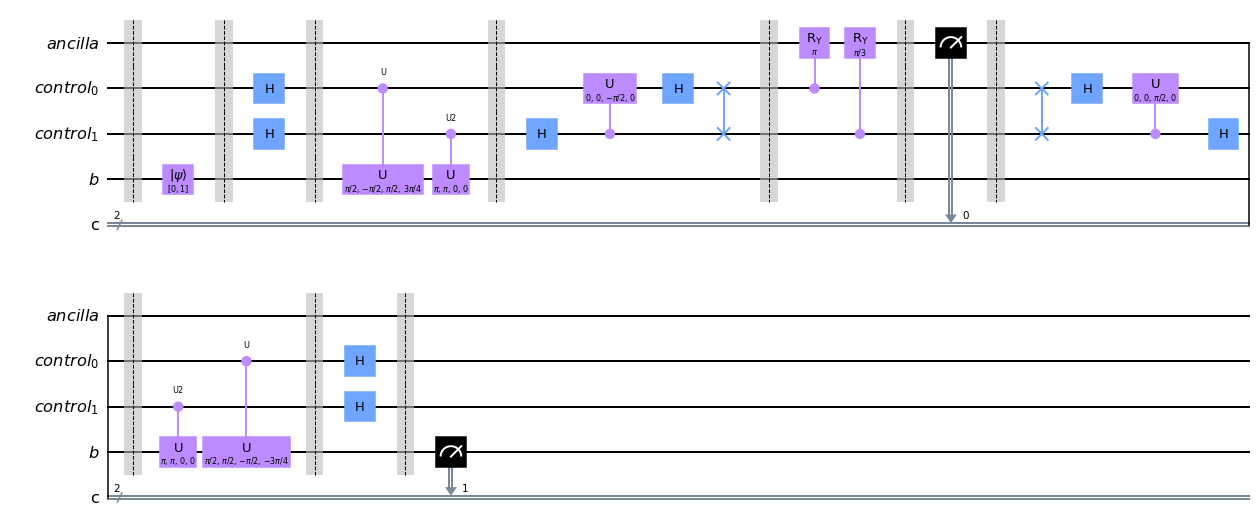

In [9]:
#----State preparation
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

#----Perform a Hadamard Transform (which is part of QPE)
circuit.h(control) 

#----Run HHL
hhl(circuit, ancilla, control, input, measurement)

#----Perform a Hadamard Transform (which is part of inverse QPE)
circuit.h(control)

circuit.barrier()

#----Final measurement
circuit.measure(input, measurement[1])
circuit.draw('mpl')

{'01': 1023, '00': 3075, '10': 3072, '11': 9214}


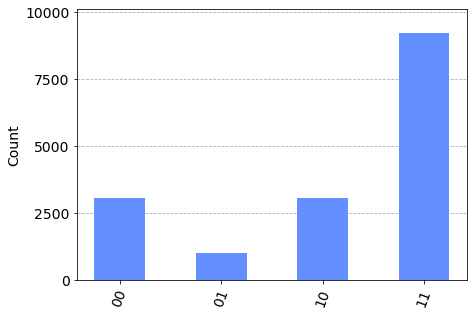

In [27]:
#----Set number of shots for the measurement
N_shots = 2**(10+4) 

#----Define backend
simulator = Aer.get_backend('qasm_simulator')

#----Execute the circuit using the QASM simulator
job_qasm = execute(circuit, backend=simulator, shots=N_shots)

#----Get the result of the execution
result = job_qasm.result()

#----Get the counts, the frequency of each answer
counts = result.get_counts()

#----Print the counts
print(counts)

#----Display the results
plot_histogram(counts, bar_labels=False)

In [28]:
#----Print the results of the measurement (probabilities!)
print('p(0_b, 0_a)=',counts['00']/sum(counts.values()))
print('p(0_b, 1_a)=',counts['01']/sum(counts.values()))
print('p(1_b, 0_a)=',counts['10']/sum(counts.values()))
print('p(1_b, 1_a)=',counts['11']/sum(counts.values()))

p(0_b, 0_a)= 0.18768310546875
p(0_b, 1_a)= 0.06243896484375
p(1_b, 0_a)= 0.1875
p(1_b, 1_a)= 0.5623779296875


## 3. Evaluation of the HHL result

Process the result of the measurement to obtain the wanted solution $x$:
- result of measurement (probabilities) to vector
- use only elements where ancilla qubit is $q_a=\vert 1 \rangle$ (which is here index 1,3 in the vector)
- use amplitudes (square root of probability of each element)
- compare with classical solution

In [29]:
#----Set number of measured qubits
Qubits = 2

#----Initialize result vector of the measurement
result_qasm = np.zeros(2**Qubits)

#----Fill result vector with probabilities --> code from seminar
for kkk in range(0,2**Qubits):
    key = format(kkk, '0' + str(Qubits)+'b')
    if key in counts:
        result_qasm[kkk] = counts[key]/(N_shots)

#----Use only elements where ancilla qubit is |1> to obtain the solution + square root to get amplitudes 
res_2nd = np.sqrt(result_qasm[1:2**Qubits:2])

#----Print output
print('measurement result (probabilities!):  ',np.round(result_qasm,4)) 
print('result where q_a=|1> (probabilities!):',np.round(result_qasm[1:2**Qubits:2],4)) 
print('result where q_a=|1> (amplitudes!):   ',np.round(res_2nd,4)) 
print('classical solution:                   ',x) 

measurement result (probabilities!):   [0.1877 0.0624 0.1875 0.5624]
result where q_a=|1> (probabilities!): [0.0624 0.5624]
result where q_a=|1> (amplitudes!):    [0.2499 0.7499]
classical solution:                    [0.375 1.125]


The **ratio** of the 2 components from HHL and the classical solution is the same, namely **1:3**.